In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Proof that reducing r^2 gives a hebbian learning rule. also, Es are reduced when weights are random. For Scalars

In [3]:
# Update variables
def step(x, e, r, U):
    with torch.no_grad():
        e = x - U(r)
    r = r + F.linear(e, U.weight.T, None) 
    return e, r

# Parameter Initialisation
U = nn.Linear(1,1, bias=False)
# U.weight.data.fill_(0.5)
print(f"U: {U.weight.data.item():.4f}")

U: 0.8428


In [4]:
# Data Initialisation
# x = torch.rand(1)
x = torch.tensor([3.0])
e = torch.zeros(1)
r = torch.zeros(1)
i = 0

print("Initial state:")
print(f"x: {x.item():.4f}")
print(f"e: {e.item():.4f}")
print(f"r: {r.item():.4f}")

Initial state:
x: 3.0000
e: 0.0000
r: 0.0000


In [397]:
# Iterate 
# for _ in range(20): # 20 - pred = 2.9625 
#     e, r = step(x, e, r, U)

i += 1
e = e.detach()
r = r.detach()
e, r = step(x, e, r, U)

print(f"state after {i} steps:")
print(f"x: {x.item():.4f}")
print(f"pred: {U(r)}")
print(f"e: {e.item():.4f}")
print(f"r: {r.item():.4f}")

state after 2 steps:
x: 3.0000
pred: 2.2852
e: 1.4644
r: 3.1940


## Train U using Hebbian learning rule 

In [25]:
# Parameter Initialisation
U = nn.Linear(1,1, bias=False)
print(f"U: {U.weight.data.item():.4f}")
preds = []
Us = []
es = []

U: 0.2809


In [26]:
lr = 0.1
epochs = 100
x = torch.tensor([-4.0])

for _ in range(epochs):
    # Data Initialisation
    x = torch.rand(1)
    # State Initialisation
    e = torch.zeros(1)
    r = torch.zeros(1)

    # Forward Pass
    for i in range(3):
        e = e.detach()
        r = r.detach()
        e, r = step(x, e, r, U)

        if i != 0:
            # Hebb Learn Using Loss func
            U.zero_grad()
            with torch.no_grad():
                U.weight.grad = -e.unsqueeze(1) * r.unsqueeze(1)  
            # loss = -0.5*((r**2).sum()) # equivalent
            # loss.backward()

            U.weight.data -= lr * U.weight.grad

    preds.append(F.linear(r, U.weight.T, U.bias).item())
    Us.append(U.weight.data.item())
    es.append(e.item())

In [22]:
e.shape, r.shape, U.weight.grad.shape

(torch.Size([1]), torch.Size([1]), torch.Size([1, 1]))

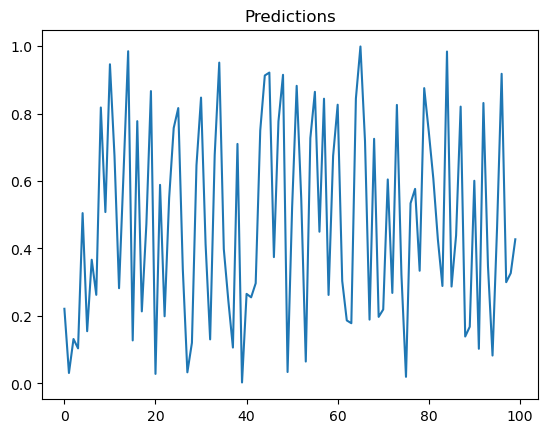

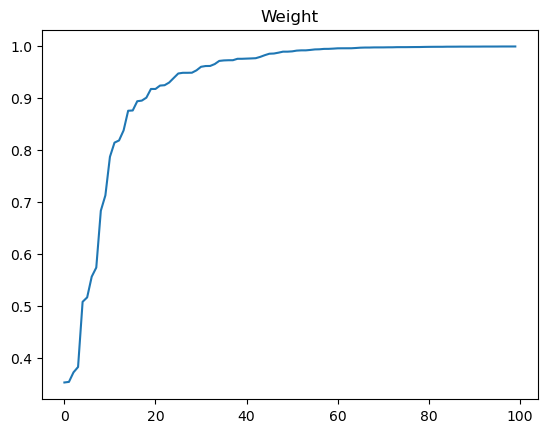

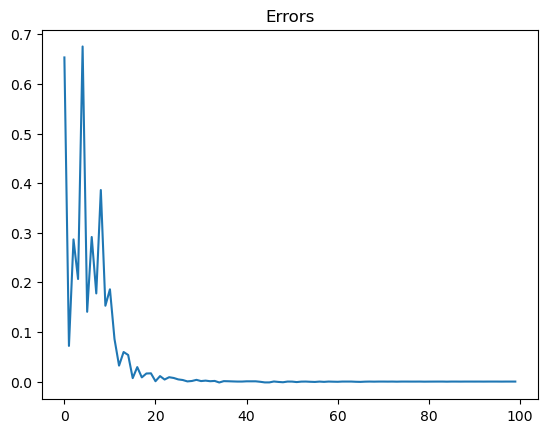

In [27]:
plt.plot(preds)
plt.title('Predictions')
plt.show()
plt.plot(Us)
plt.title('Weight')
plt.show()
plt.plot(es,)
plt.title('Errors')
plt.show()

For any x, U converges to either -1 or +1, depending on which is closer at initialisation.

# Forward and back connections don't have to be symmetric, just same sign

In [34]:
# New Update rule with assymetric weights
def step2(x, e, r, U, V):
    with torch.no_grad():
        e = x - U(r)
    r = r + F.linear(e, V.weight, None) 
    return e, r

# Parameter Initialisation
U = nn.Linear(1,1, bias=True)
V = nn.Linear(1,1, bias=False)

print(f"U: {U.weight.data.item():.4f}")
print(f"V: {V.weight.data.item():.4f}")

U: 0.6923
V: -0.3418


In [182]:
# Data Initialisation
# x = torch.rand(1)
x = torch.tensor([3.0])
e = torch.zeros(1)
r = torch.zeros(1)

print(f"x: {x.item():.4f}")
print(f"e: {e.item():.4f}")
print(f"r: {r.item():.4f}")

x: 3.0000
e: 0.0000
r: 0.0000


In [223]:
# Iterate 
# for _ in range(20): # 20 - pred = 2.9625 
#     e, r = step(x, e, r, U)

e = e.detach()
r = r.detach()
e, r = step2(x, e, r, U, V)


print(f"x: {x.item():.4f}")
print(f"pred: {F.linear(r, U.weight.T, U.bias).item():.4f}")
print(f"e: {e.item():.4f}")
print(f"r: {r.item():.4f}")

x: 3.0000
pred: 2.8607
e: 0.1510
r: -19.5755


In [72]:
# Parameter Initialisation
U = nn.Linear(1,1, bias=False)
V = nn.Linear(1,1, bias=False)
print(f"U: {U.weight.data.item():.4f}")
print(f"V: {V.weight.data.item():.4f}")
preds = []
Us = []
Vs = []
es = []

U: 0.1917
V: -0.1158


In [73]:
lr = 0.1
epochs = 100
x = torch.tensor([-4.0])

for _ in range(epochs):
    # Data Initialisation
    x = torch.rand(1)
    # State Initialisation
    e = torch.zeros(1)
    r = torch.zeros(1)

    # Forward Pass
    for i in range(3):
        e = e.detach()
        r = r.detach()
        e, r = step2(x, e, r, U, V)

        U.zero_grad()
        V.zero_grad()
        with torch.no_grad():
            e = x - F.linear(r, U.weight, U.bias)
            if i != 0:
                U.weight.grad = -(e.unsqueeze(1) * r.unsqueeze(1))

            r = r + F.linear(e, V.weight, None) 
            if i != 0:
                V.weight.grad = -(e.unsqueeze(1) * r.unsqueeze(1))

                U.weight.data -= lr * U.weight.grad
                V.weight.data -= lr * V.weight.grad

        # if i != 0:
        #     # Hebb Learn Using Loss func
        #     U.zero_grad()
        #     V.zero_grad()
        #     with torch.no_grad():
        #         U.weight.grad = -e.unsqueeze(1) * r.unsqueeze(1)  
        #         V.weight.grad = -e.unsqueeze(1) * r.unsqueeze(1)
        #     # loss = -0.5*((r**2).sum()) # equivalent
        #     # loss.backward()

        #     U.weight.data -= lr * U.weight.grad
        #     V.weight.data -= lr * V.weight.grad

    preds.append(F.linear(r, U.weight.T, U.bias).item())
    Us.append(U.weight.data.item())
    Vs.append(V.weight.data.item())
    es.append(e.item())

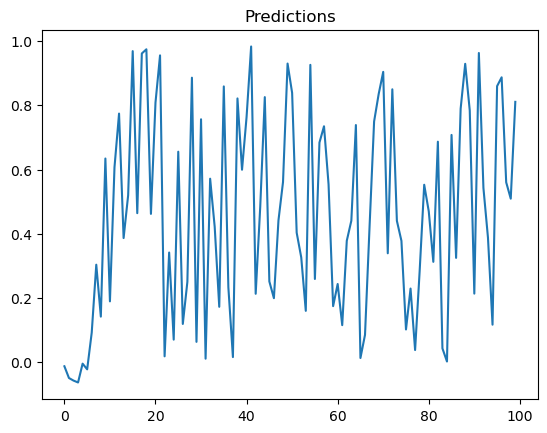

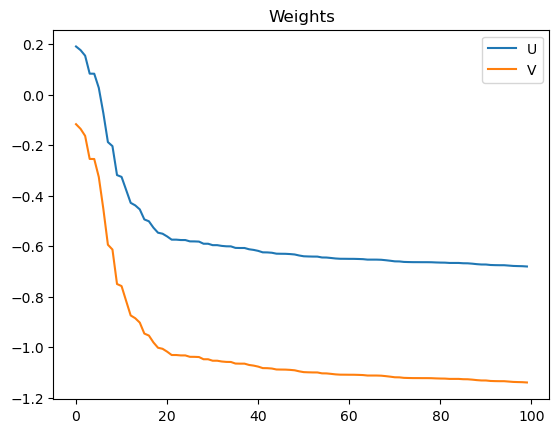

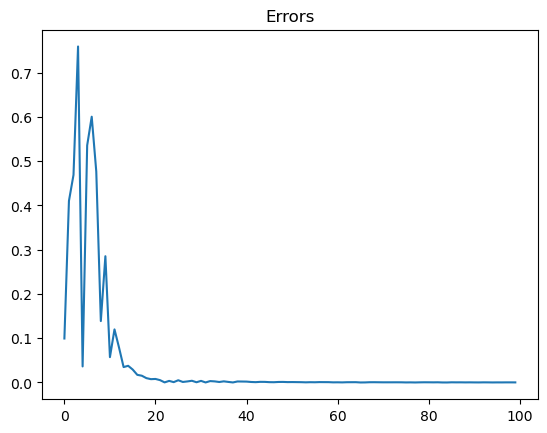

In [75]:
plt.plot(preds)
plt.title('Predictions')
plt.show()
plt.plot(Us, label="U")
plt.title('Weights')
plt.plot(Vs, label="V")
plt.legend()
plt.show()
plt.plot(es,)
plt.title('Errors')
plt.show()